# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.5MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Fri Jan 29 04:46:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/HUFS_AIcamp/data'
os.listdir(data_dir)

['ko_32000.model', 'ko_32000.vocab', 'kowiki', 'nsmc']

In [7]:
# nsmc dir
nsmc_dir = os.path.join(data_dir, 'nsmc')
if not os.path.exists(nsmc_dir):
    os.makedirs(nsmc_dir)
os.listdir(nsmc_dir)

['ratings_train.txt', 'ratings_test.txt', 'stub.csv', 'stub.hdf5']

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 47  # number of sequence
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [10]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [1, 0]  # 긍정(1), 부정(0)

In [11]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [12]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train label
train_labels = labels

# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs, train_labels

(array([[2, 3, 4, 5],
        [2, 3, 6, 0]]), array([1, 0]))

In [13]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 5)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
array([[[ 0.02688133, -0.00167429,  0.00873896, -0.04772998,
         -0.00643448],
        [ 0.04782395,  0.04810704, -0.03535189,  0.04945729,
          0.02813626],
        [-0.02798697, -0.00110071,  0.0133124 ,  0.00637371,
         -0.00963336],
        [-0.01013004,  0.01826939,  0.02741292, -0.00544795,
         -0.04431503]],

       [[ 0.02688133, -0.00167429,  0.00873896, -0.04772998,
         -0.00643448],
        [ 0.04782395,  0.04810704, -0.03535189,  0.04945729,
          0.02813626],
        [-0.02540476, -0.0194685 , -0.01826397, -0.03069841,
          0.03251565],
        [ 0.00380393, -0.01353813,  0.00816301, -0.02561716,
         -0.00696643]]], dtype=float32)>

In [14]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool = pool(hidden)
hidden_pool

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.04782395, 0.04810704, 0.02741292, 0.04945729, 0.02813626],
       [0.04782395, 0.04810704, 0.00873896, 0.04945729, 0.03251565]],
      dtype=float32)>

In [15]:
# 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
outputs = linear(hidden_pool)
outputs

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5086928 , 0.49130723],
       [0.5060627 , 0.49393737]], dtype=float32)>

In [16]:
# 예측을 위한 wegiths
weight, bias = linear.get_weights()
weight, bias

(array([[-0.32336175, -0.66899645],
        [ 0.27413416, -0.36288744],
        [-0.3022557 , -0.68477273],
        [ 0.38106263,  0.40476227],
        [-0.20340782,  0.56833684]], dtype=float32),
 array([0., 0.], dtype=float32))

In [17]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    문장의 감정분류 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    ######################################################
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)
    rnn_1 = tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = 128, return_sequences = True))
    hidden = rnn_1(hidden)
    rnn_2 = tf.keras.layers.SimpleRNN(units = 128, return_sequences = True)
    hidden = rnn_2(hidden)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)
    
    linear = tf.keras.layers.Dense(n_out, activation = tf.nn.softmax)
    outputs = linear(hidden_pool)
    ######################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 4, 8)              56        
_________________________________________________________________
bidirectional (Bidirectional (None, 4, 256)            35072     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 4, 128)            49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 84,666
Trainable params: 84,666
Non-trainable params: 0
_________________________________________________________

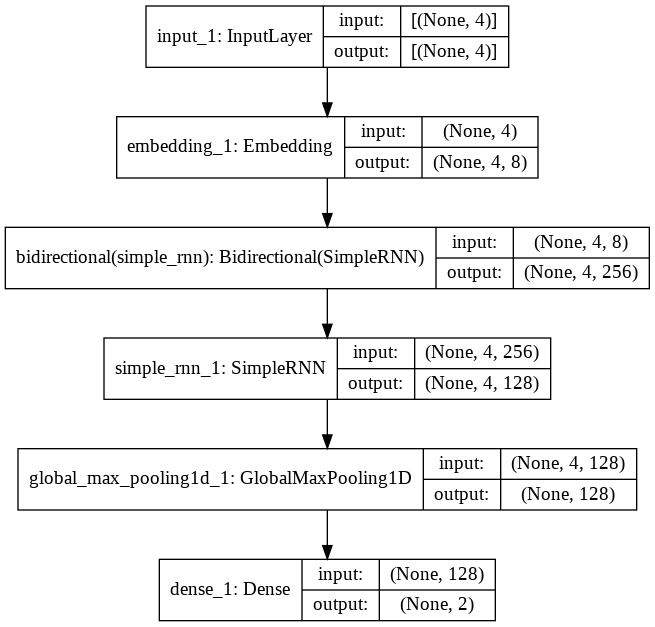

In [18]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 2)
# 모델 내용 그래프 출력
model.summary()
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [19]:
model.predict(train_inputs)

array([[0.47278282, 0.52721715],
       [0.46202654, 0.53797346]], dtype=float32)

# 다운로드
- https://github.com/e9t/nsmc

In [20]:
!wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt

--2021-01-29 04:49:14--  https://github.com/e9t/nsmc/raw/master/ratings_train.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt [following]
--2021-01-29 04:49:14--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  42.2MB/s    in 0.3s    

2021-01-29 04:49:15 (42.2 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2021-01-29 04:49:15--  https://github.com/e9t/nsmc/raw/master/

In [21]:
shutil.move('ratings_train.txt', os.path.join(nsmc_dir, 'ratings_train.txt'))
shutil.move('ratings_test.txt', os.path.join(nsmc_dir, 'ratings_test.txt'))
os.listdir(nsmc_dir)

['ratings_train.txt', 'ratings_test.txt', 'stub.csv', 'stub.hdf5']

# 데이터 분석

In [23]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [24]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## Char

In [26]:
# char 길이 데이터
char_len = df_train["document"].astype("str").apply(len)
char_len.head(10)

0    19
1    33
2    17
3    29
4    61
5    45
6    21
7    86
8    22
9    45
Name: document, dtype: int64

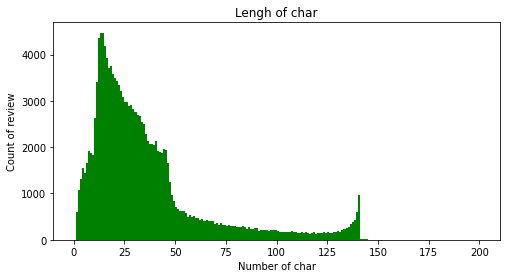

In [28]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=200, range=[0, 200], facecolor='g', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [29]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:     146
char 길이 최소:       1
char 길이 평균:      35.20
char 길이 표준편차:   29.53
char 25/100분위:    16.00
char 50/100분위:    27.00
char 75/100분위:    42.00
char IQR:          26.00
char MAX/100분위:   81.00


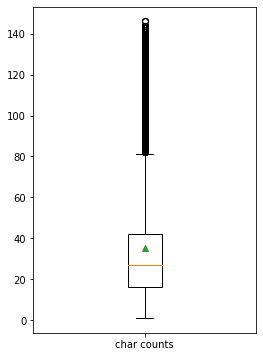

In [30]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

## Word

In [31]:
# word 길이 데이터
word_len = df_train['document'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0     5
1     4
2     1
3     6
4    11
5     8
6     4
7    13
8     6
9    10
Name: document, dtype: int64

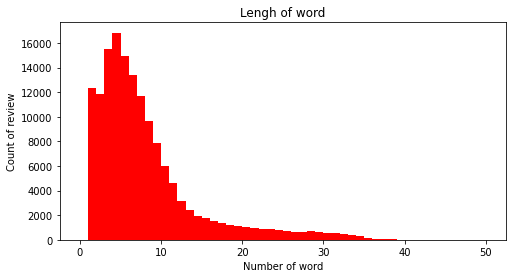

In [32]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=50, range=[0, 50], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [33]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      41
word 길이 최소:       1
word 길이 평균:       7.59
word 길이 표준편차:    6.51
word 25/100분위:     3.00
word 50/100분위:     6.00
word 75/100분위:     9.00
word IQR:           6.00
word MAX/100분위:   18.00


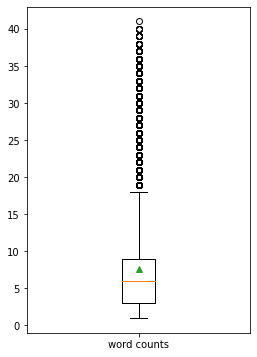

In [34]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

In [35]:
# word 길이 데이터
spm_len = df_train['document'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0    11
1    25
2    11
3    18
4    38
5    33
6    11
7    61
8    10
9    29
Name: document, dtype: int64

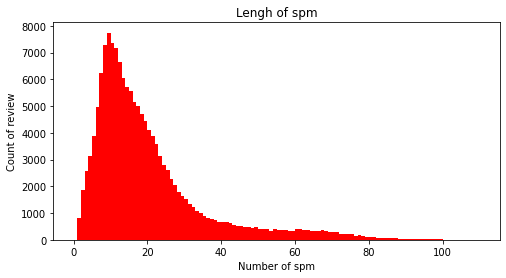

In [36]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=110, range=[0, 110], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [37]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:     141
spm 길이 최소:       1
spm 길이 평균:      19.77
spm 길이 표준편차:   15.87
spm 25/100분위:     9.00
spm 50/100분위:    15.00
spm 75/100분위:    24.00
spm IQR:          15.00
spm MAX/100분위:   46.50


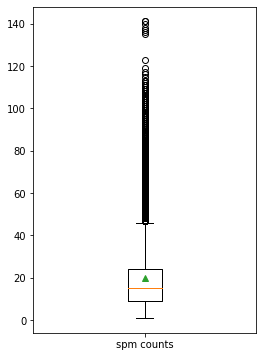

In [38]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Label

In [39]:
df_train['label'].value_counts()

0    75170
1    74825
Name: label, dtype: int64

In [40]:
# label count
print(f"부정 리뷰 개수: {df_train['label'].value_counts()[0]}")
print(f"긍정 리뷰 개수: {df_train['label'].value_counts()[1]}")

부정 리뷰 개수: 75170
긍정 리뷰 개수: 74825


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


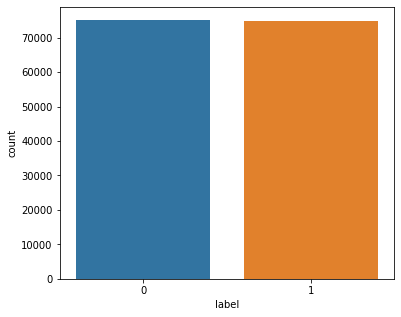

In [41]:
# label counter plot
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 5)
# https://seaborn.pydata.org/
subplt = sns.countplot(df_train['label'])

## Word Cloud

In [82]:
# train review documents
train_review = [review for review in df_train['document'] if type(review) is str]
train_review[:10]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']

In [83]:
' '.join(train_review[:10])

'아 더빙.. 진짜 짜증나네요 목소리 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 너무재밓었다그래서보는것을추천한다 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. 원작의 긴장감을 제대로 살려내지못했다. 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 액션이 없는데도 재미 있는 몇안되는 영화 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?'

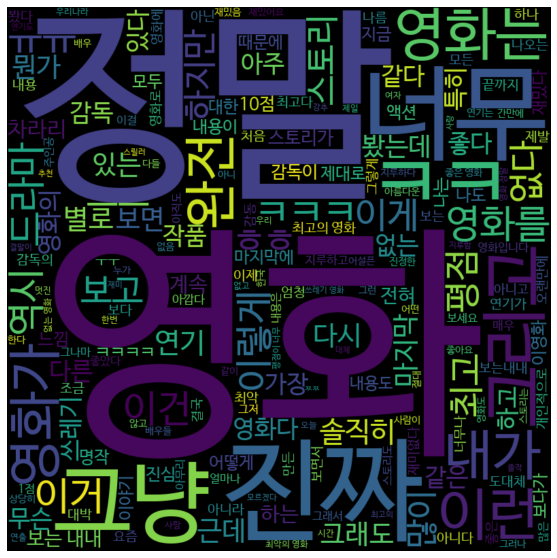

In [84]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sample Data Project

## Data


In [42]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [43]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [44]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [45]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [46]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

,id,document,label
42986,9868530,공포 영화는 무슨...,0
25002,7745536,중심이 단단해야 이야기의 파급력도 커지는 법,0
104366,7951197,왜 공포스릴러에 코믹만 잔뜩들어간건데 근데 재미도없어,0
71235,6879284,인트로부터 결말까지하며 여운까지 완벽했던 애니메이션,1
118309,9441802,솔직히 시즌1이 전설이었지.,0
31809,8917151,참 할 말없게 만드네~~~ 몇십억대 집부터 이번에 캠핑카 까지~~ 한번 장볼때마다 ...,0
92264,9332061,옵대장과 나의 의리는 여기서부터 시작됬다,1
130960,9131754,그사람추기경을보러갔어요상영시작부터끝날때까지한순간도눈으뗄수가없고빠져들었습니다 우리나라...,1
113333,4673262,대박좋아요 너무잘만들었어요!,1
64882,9503750,영화가 점점 뒤로 갈수록 짜증나네~ㅋ,0


In [47]:
# 랜덤하게 10개만 확인
df_test = df_test.sample(10)
df_test

,id,document,label
4994,1852644,장난? ㅋ,0
5743,7871316,처음 오프닝 부분에 동네 주민 인터뷰.. 경찰청 사람들의 형사들도 이보단 자연스러웠...,0
19252,6794224,오글오글 발연기 진리콧물흘리는 유노윤호모습이 떠오르네,0
16263,8515669,이 명작이 왜 7점밖에 안될까요? 평점만 보고 안보려고 했다가 안봤다면 후회할 뻔한...,1
48841,5352737,올 봄 당신들의 가슴속에 각인 될 단 하나의 똥쓰레기 작품이 온다 에어리언 대 거미,1
29056,7999154,11111111,1
31231,3950845,아~~재미없어~~~,0
27711,9962436,이 영화보고 울었다...,1
46728,10047874,리메이크 없나요 ... 아~ 또 보고싶다 극장에서 ..,1
28939,4896895,독특한 소재를 참 심심하게 만들어내는 능력이 있는 감독,0


In [49]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        ######################################
        print()
        label = row['label']
        document = row['document']
        print(label, document)
        tokens = vocab.encode_as_pieces(document)
        print(len(tokens), ':', tokens)
        token_ids = vocab.encode_as_ids(document)
        print(len(token_ids), ':', token_ids)
        # 긴 토큰은 길이를 줄임
        token_ids = token_ids[:n_seq]
        print(len(token_ids), ':', token_ids)
        # 짧은 토큰은 pad 추가
        token_ids += [0] * (n_seq - len(token_ids))
        print(len(token_ids), ':', token_ids)
        # 값 저장
        labels[index] = label
        inputs[index] = token_ids
        index += 1
        ######################################
    return inputs, labels

In [50]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels


0 공포 영화는 무슨...
6 : ['▁공포', '▁영화는', '▁무슨', '.', '.', '.']
6 : [3029, 4305, 13559, 7, 7, 7]
6 : [3029, 4305, 13559, 7, 7, 7]
47 : [3029, 4305, 13559, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0 중심이 단단해야 이야기의 파급력도 커지는 법
12 : ['▁중심이', '▁단단', '해야', '▁이야기', '의', '▁파', '급', '력', '도', '▁커', '지는', '▁법']
12 : [8718, 18512, 755, 1212, 9, 437, 444, 908, 32, 1598, 873, 961]
12 : [8718, 18512, 755, 1212, 9, 437, 444, 908, 32, 1598, 873, 961]
47 : [8718, 18512, 755, 1212, 9, 437, 444, 908, 32, 1598, 873, 961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0 왜 공포스릴러에 코믹만 잔뜩들어간건데 근데 재미도없어
20 : ['▁왜', '▁공포', '스', '릴', '러', '에', '▁코믹', '만', '▁잔', '뜩', '들어', '간', '건', '데', '▁근', '데', '▁재미', '도', '없', '어']
20 : [2761, 3029, 86, 1268, 447, 13, 14741, 62, 2368, 30159, 6227, 355, 735, 298, 1817, 298, 16577, 32, 11654, 110]
20 : [2761, 3029, 86, 1268, 447, 13, 1

(array([[ 3029,  4305, 13559,     7,     7,     7,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [ 8718, 18512,   755,  1212,     9,   437,   444,   908,    32,
          1598,   873,   961,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [ 2761,  3029,    86,  1268,   447,    13, 14741,    62,  2368,
         30159,  6227,   355,   735,   298,  1817,   298, 16577,    32,
         11654,   110,     0,     0,     0,     0,     0,     0,     0,
             0, 

In [51]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels


0 장난? ㅋ
4 : ['▁장난', '?', '▁', 'ᄏ']
4 : [18006, 1860, 10, 31026]
4 : [18006, 1860, 10, 31026]
47 : [18006, 1860, 10, 31026, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0 처음 오프닝 부분에 동네 주민 인터뷰.. 경찰청 사람들의 형사들도 이보단 자연스러웠다.연기자고 엑스트라고 오그라드는 발연기에 소름이 돋는다. AV연기가 더 낫다 레알.. 솔직히 내가 해도 저거보단 낫겠다 싶다
57 : ['▁처음', '▁오프닝', '▁부분에', '▁동네', '▁주민', '▁인터뷰', '.', '.', '▁경찰청', '▁사람들의', '▁형사', '들도', '▁이', '보', '단', '▁자연', '스러웠', '다', '.', '연기', '자', '고', '▁엑스트라', '고', '▁오', '그라드', '는', '▁발', '연기', '에', '▁소', '름', '이', '▁돋', '는', '다', '.', '▁AV', '연기', '가', '▁더', '▁낫', '다', '▁레알', '.', '.', '▁솔직', '히', '▁내가', '▁해도', '▁저', '거', '보', '단', '▁낫', '겠다', '▁싶다']
57 : [626, 11360, 6048, 15295, 4134, 9695, 7, 7, 18896, 4356, 5575, 2587, 29, 191, 342, 935, 27960, 50, 7, 19391, 71, 37, 28992, 37, 178, 22696, 11, 709, 19391, 13, 236, 1684, 17, 25223, 11, 50, 7, 17093, 19391, 19, 149, 14855, 50, 5565, 7, 7, 25261, 363, 7349, 4787, 811, 439

(array([[18006,  1860,    10, 31026,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  626, 11360,  6048, 15295,  4134,  9695,     7,     7, 18896,
          4356,  5575,  2587,    29,   191,   342,   935, 27960,    50,
             7, 19391,    71,    37, 28992,    37,   178, 22696,    11,
           709, 19391,    13,   236,  1684,    17, 25223,    11,    50,
             7, 17093, 19391,    19,   149, 14855,    50,  5565,     7,
             7, 25261],
        [  178,  2426,   177,  2426,   709, 19391, 10280, 26940,   505,
          6839,  1821,   216,   217,  1304,   158,   296,  2099,    17,
         17099,   343,     0,     0,     0,     0,     0,     0,     0,
             0, 

## 학습

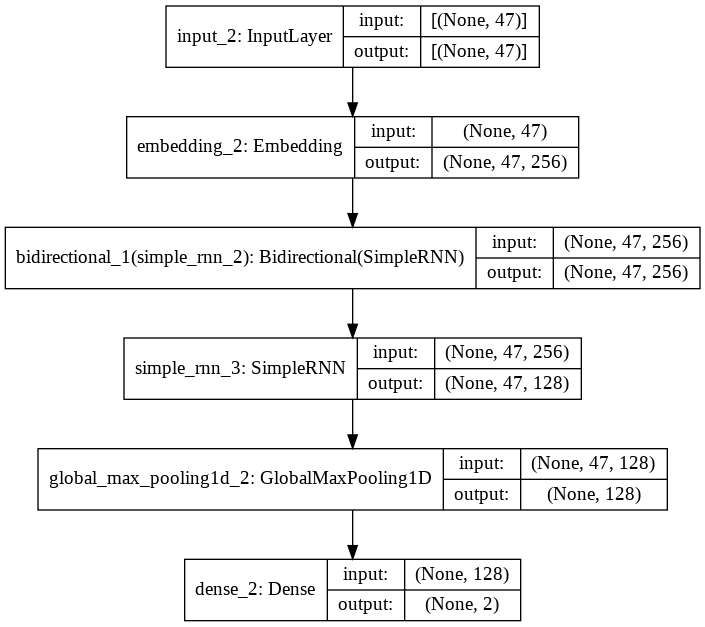

In [52]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [53]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
# 모델 학습
history = model.fit(train_inputs, train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7595 - accuracy: 0.5000 - val_loss: 0.7365 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 245ms/step - loss: 0.5580 - accuracy: 0.7000 - val_loss: 0.7087 - val_accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 251ms/step - loss: 0.4133 - accuracy: 0.9000 - val_loss: 0.7141 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 184ms/step - loss: 0.3005 - accuracy: 1.0000 - val_loss: 0.7201 - val_accuracy: 0.6000
Epoch 5/100
1/1 [==============================] - 0s 200ms/step - loss: 0.2125 - accuracy: 1.0000 - val_loss: 0.7616 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 187ms/step - loss: 0.1488 - accuracy: 1.0000 - val_loss: 0.8120 - val_accuracy: 0.6000
Epoch 7/100
1/1 [==============================] - 0s 190ms/step - loss: 0.1052 - accuracy: 1.0000 - val_loss: 0.8612 - val_accuracy: 0.6000
Epoch 8/100
1/1 

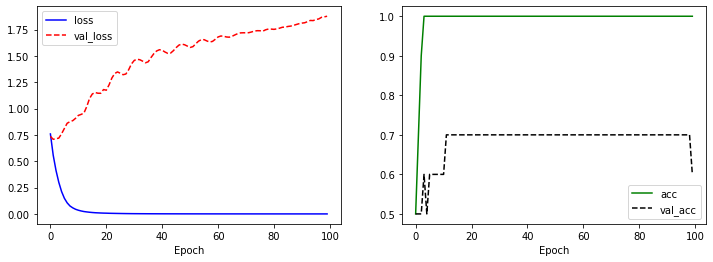

In [55]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 학습 2

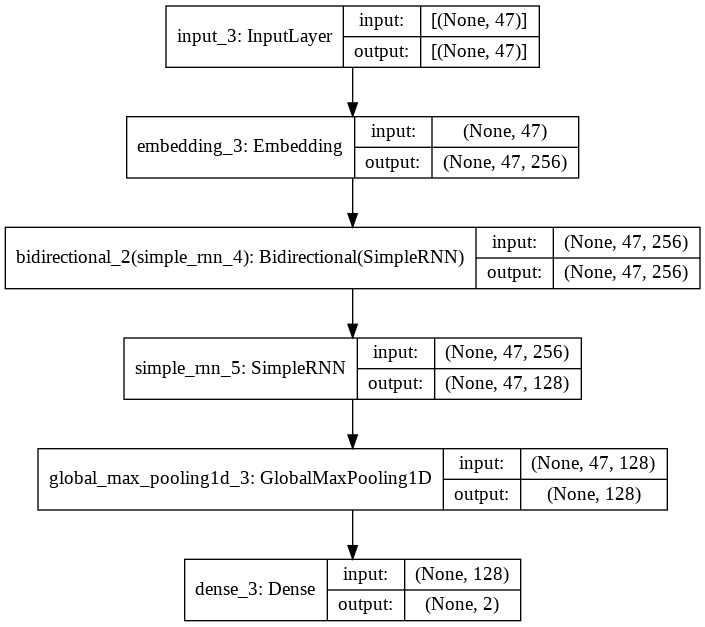

In [56]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [57]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [59]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.7407 - accuracy: 0.6000 - val_loss: 0.7544 - val_accuracy: 0.4000

Epoch 00001: val_accuracy improved from -inf to 0.40000, saving model to /content/drive/MyDrive/HUFS_AIcamp/data/nsmc/stub.hdf5
Epoch 2/100
1/1 [==============================] - 0s 210ms/step - loss: 0.5533 - accuracy: 0.6000 - val_loss: 0.7967 - val_accuracy: 0.5000

Epoch 00002: val_accuracy improved from 0.40000 to 0.50000, saving model to /content/drive/MyDrive/HUFS_AIcamp/data/nsmc/stub.hdf5
Epoch 3/100
1/1 [==============================] - 0s 199ms/step - loss: 0.3837 - accuracy: 0.7000 - val_loss: 0.7799 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/100
1/1 [==============================] - 0s 237ms/step - loss: 0.2787 - accuracy: 1.0000 - val_loss: 0.7082 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/100
1/1 [==============================] - 0s 210ms/step -

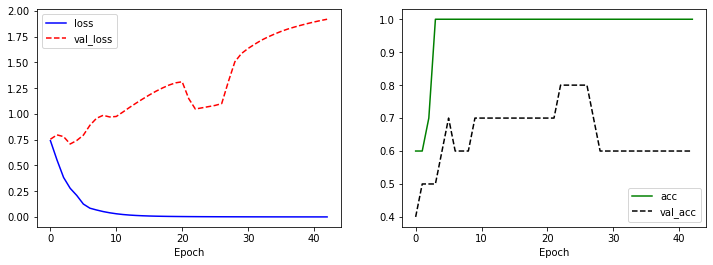

In [60]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [61]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [62]:
# 예측
logits = model.predict(test_inputs)
logits

array([[0.9919423 , 0.00805769],
       [0.9812159 , 0.01878406],
       [0.9021979 , 0.09780208],
       [0.02086356, 0.97913647],
       [0.06346834, 0.93653166],
       [0.99470323, 0.00529678],
       [0.9916932 , 0.00830678],
       [0.99306947, 0.00693049],
       [0.02236035, 0.9776397 ],
       [0.9868167 , 0.01318335]], dtype=float32)

In [63]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis = -1)
test_preds

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0])

In [64]:
# confusion matrix
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[5, 0],
       [2, 3]])

In [65]:
# accuracy, precision, recall, f1
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.8
precision: 1.0
recall: 0.6
f1: 0.7499999999999999


In [66]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    # token 생성 : <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis = -1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [67]:
string = '영화 너무 재밌어'
do_predict(model, n_seq, string)

'부정'

In [140]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")

input > 영화 재미없어
output > 부정
input > 영화 보면 잠이 잘와
output > 부정
input > 배고파
output > 부정
input > 기분 좋아
output > 부정
input > 기분 좋다니까
output > 부정
input > 영화 재밌어요
output > 부정
input > 

KeyboardInterrupt: ignored

# All Data Project

## Data


In [68]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [69]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [70]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [71]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [72]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        label = row['label']
        document = row['document']
        # print(label, document)
        tokens = vocab.encode_as_pieces(document)
        # print(len(tokens), ':', tokens)
        token_ids = vocab.encode_as_ids(document)
        # print(len(token_ids), ':', token_ids)
        token_ids = token_ids[:n_seq]
        # print(len(token_ids), ':', token_ids)
        token_ids += [0] * (n_seq - len(token_ids))
        # print(len(token_ids), ':', token_ids)

        labels[index] = label
        inputs[index] = token_ids
        index += 1
    return inputs, labels

In [73]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

(array([[  188, 16337,     7, ...,     0,     0,     0],
        [15825,     7,     7, ...,     0,     0,     0],
        [ 2329,   349,     1, ...,     0,     0,     0],
        ...,
        [   29,   128, 19999, ...,     0,     0,     0],
        [14943,  7071,   802, ...,     0,     0,     0],
        [  253,   321,  1071, ...,     0,     0,     0]], dtype=int32),
 array([0., 1., 0., ..., 0., 1., 0.]))

In [74]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

(array([[ 5441,    10, 31026, ...,     0,     0,     0],
        [  618,   509,   798, ...,     0,     0,     0],
        [19999,   173,    29, ...,     0,     0,     0],
        ...,
        [ 2087,    32, 22687, ...,     0,     0,     0],
        [ 3991, 27855,    11, ...,     0,     0,     0],
        [ 4404,    11,   375, ...,     0,     0,     0]], dtype=int32),
 array([1., 0., 0., ..., 0., 0., 0.]))

## 학습

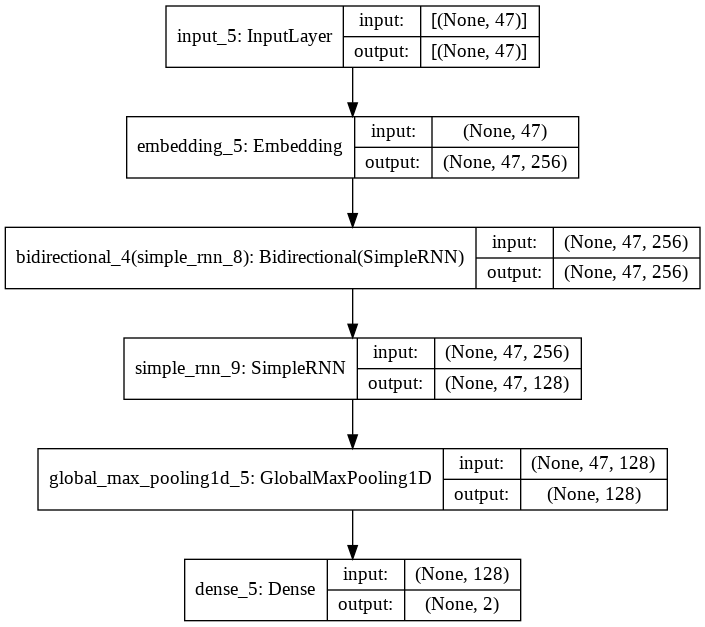

In [75]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [76]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [78]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
586/586 [==============================] - 104s 175ms/step - loss: 0.4810 - accuracy: 0.7568 - val_loss: 0.3502 - val_accuracy: 0.8459

Epoch 00001: val_accuracy improved from -inf to 0.84593, saving model to /content/drive/MyDrive/HUFS_AIcamp/data/nsmc/stub.hdf5
Epoch 2/100
586/586 [==============================] - 101s 173ms/step - loss: 0.2879 - accuracy: 0.8821 - val_loss: 0.3485 - val_accuracy: 0.8495

Epoch 00002: val_accuracy improved from 0.84593 to 0.84953, saving model to /content/drive/MyDrive/HUFS_AIcamp/data/nsmc/stub.hdf5
Epoch 3/100
586/586 [==============================] - 102s 174ms/step - loss: 0.2021 - accuracy: 0.9230 - val_loss: 0.3729 - val_accuracy: 0.8416

Epoch 00003: val_accuracy did not improve from 0.84953
Epoch 4/100
586/586 [==============================] - 102s 174ms/step - loss: 0.1313 - accuracy: 0.9532 - val_loss: 0.4457 - val_accuracy: 0.8388

Epoch 00004: val_accuracy did not improve from 0.84953
Epoch 5/100
586/586 [==================

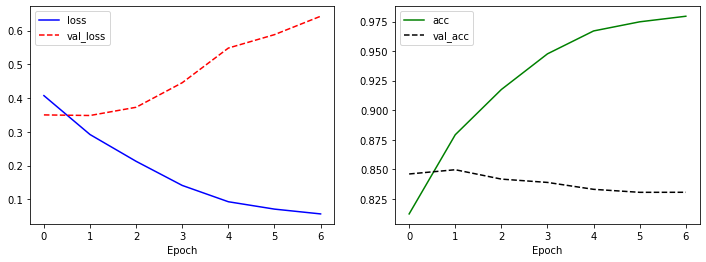

In [79]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [80]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [81]:
# 예측
logits = model.predict(test_inputs)
logits

array([[0.04560994, 0.9543901 ],
       [0.117578  , 0.88242203],
       [0.33721343, 0.6627866 ],
       ...,
       [0.01685572, 0.9831443 ],
       [0.9953408 , 0.00465924],
       [0.6835109 , 0.3164891 ]], dtype=float32)

In [83]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis=-1)
test_preds

array([1, 1, 1, ..., 1, 0, 0])

In [84]:
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[20709,  4117],
       [ 3406, 21765]])

In [85]:
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.8495309718583115
precision: 0.8409319217989336
recall: 0.864685550832307
f1: 0.8526433314398763


In [86]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    # token 생성: <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis=-1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [87]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")

input > 재밌다
output > 긍정
input > 재미있다
output > 긍정
input > 졸립다
output > 부정
input > 영화 개재밌네
output > 긍정
input > 

KeyboardInterrupt: ignored